# Using a Pretrained ConvNet
This notebook utilizes a pretrained convnet to do feature extraction and fine-tuning for a specific image problem. We will be using the VGG16 CNN model pretrained on the ImageNet dataset to classify images of cats and dogs.

In [0]:
%tensorflow_version 2.x
from tensorflow.keras.applications import VGG16
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
# Initialize VGG16 conv base (no dense layers)
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Fast feature extraction - no data augmentation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### Mount google drive first ###
base_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/Deep Learning in Python/Deep Learning for Computer Vision'
original_dataset_dir = base_dir + '/kaggle_cat_dog_orig_smaller' # location of original uncompressed dataset

# Directories for train / validation /test data splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# train
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# validation
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#test
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [0]:
# Extract features with pretrained conv base
datagen = ImageDataGenerator(rescale=1/255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512)) # conv base output shape
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(150,150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i+1) * batch_size] = features_batch
    labels[i * batch_size : (i+1) * batch_size] = labels_batch
    i += 1
    # Break condition for generator
    if i * batch_size >= sample_count:
      break
  return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# Flatten features prior to input into dense layer
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# Training densely connected classifier
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    validation_data=(validation_features, validation_labels)
)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 553us/sample - loss: 0.6359 - acc: 0.6410 - val_loss: 0.4726 - val_acc: 0.8170
Epoch 2/30
2000/2000 [==============================] - 0s 199us/sample - loss: 0.4757 - acc: 0.7720 - val_loss: 0.3913 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 0s 208us/sample - loss: 0.3854 - acc: 0.8365 - val_loss: 0.3461 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 0s 229us/sample - loss: 0.3380 - acc: 0.8590 - val_loss: 0.3217 - val_acc: 0.8800
Epoch 5/30
2000/2000 [==============================] - 0s 207us/sample - loss: 0.3037 - acc: 0.8770 - val_loss: 0.3020 - val_acc: 0.8860
Epoch 6/30
2000/2000 [==============================] - 0s 222us/sample - loss: 0.2843 - acc: 0.8890 - val_loss: 0.2890 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 0s 208us/sample - loss: 0.2621 - acc: 0.8985 - val_loss: 0.2915 - va

In [0]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

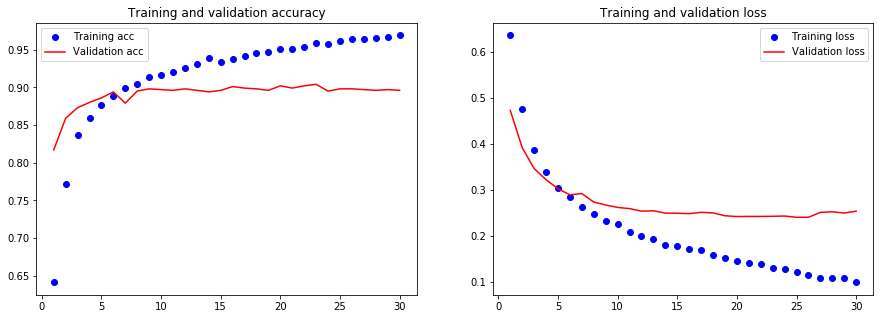

In [0]:
# Plot training / validation results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

fig,a =  plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

a[0].plot(epochs, acc, 'bo', label='Training acc')
a[0].plot(epochs, val_acc, 'r', label='Validation acc')
a[0].set_title('Training and validation accuracy')
a[0].legend()

a[1].plot(epochs, loss, 'bo', label='Training loss')
a[1].plot(epochs, val_loss, 'r', label='Validation loss')
a[1].set_title('Training and validation loss')
a[1].legend()

plt.show()

We manage to reach a validation acuracy of 90%, which is much better than when we trained  small model from scratch. The plots also indicate that we begin overfitting after a ~10 epochs despite implementing a large dropout rate. To mitigate overfitting we can include data augmentation.

## Feature extraction with Data Augmentation
While more expensive than without, using data augmentation alongside the base convolutional model should allow us to reduce the effects of overfitting the small image dataset.

In [0]:
# Control Freezing of conv base weights
conv_base.trainable = False

In [0]:
# Add densely connected classifier to output of the base conv model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# Train the end to end model with frozen conv base
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = 50
)

# Save weights before fine-tuning
weight_checkpoint = model.get_weights()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 26s 255ms/step - loss: 0.5320 - acc: 0.7225 - val_loss: 0.3740 - val_acc: 0.8240
Epoch 2/30
100/100 [==============================] - 24s 242ms/step - loss: 0.4395 - acc: 0.7875 - val_loss: 0.3398 - val_acc: 0.8440
Epoch 3/30
100/100 [==============================] - 25s 247ms/step - loss: 0.4172 - acc: 0.8050 - val_loss: 0.2995 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 24s 245ms/step - loss: 0.3920 - acc: 0.8195 - val_loss: 0.2659 - val_acc: 0.8880
Epoch 5/30
100/100 [==============================] - 24s 245ms/step - loss: 0.3903 - acc: 0.8215 - val_loss: 0.3314 - val_acc: 0.8530
Epoch 6/30
100/100 [==============================] - 24s 245ms/step - loss: 0.3801 - acc: 0.8330 - val_loss: 0.2733 - val_acc: 0.8900
Epoch 7/30
10

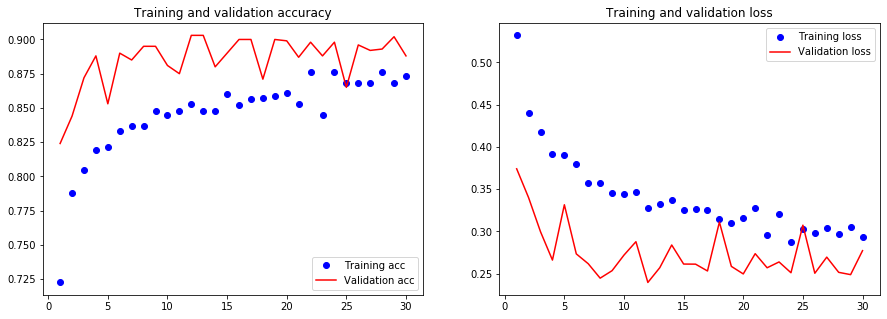

In [0]:
# Plot training / validation results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

fig,a =  plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

a[0].plot(epochs, acc, 'bo', label='Training acc')
a[0].plot(epochs, val_acc, 'r', label='Validation acc')
a[0].set_title('Training and validation accuracy')
a[0].legend()

a[1].plot(epochs, loss, 'bo', label='Training loss')
a[1].plot(epochs, val_loss, 'r', label='Validation loss')
a[1].set_title('Training and validation loss')
a[1].legend()

plt.show()

Using augmented data as opposed to a dropout layer, we achieve similar performance on validation data with ~90% accuracy.

### Fine-tuning the pretrained model
To further fine tune our pretrained model for the cat vs dog image classification problem, we can unfreeze a few of the top layers of the pretrained base conv architecture and retrain both theses unfrozen layers and the top densely connected layers. This will allow the pretrained model to be more relevant for our specific problem.

To fine-tune the network the following steps are followed:
1. Add custom network on top of pretrained network
2. Freeze the pretrained base network
3. Train the added custom layers
4. Unfreeze some top layers of the base network
5. Train both the unfrozen layers and the added custom layers

Since we've already completed steps 1-3 in the previous section, we'll continue with step 4.

In [0]:
# Set model weights from checkpoint
model.set_weights(weight_checkpoint)

# Unfreeze Weights of only "block3 to block5" of base conv model
conv_base.trainable = True

for layer in conv_base.layers:
  print(layer.name)
  if layer.name.startswith(('block3','block4','block5')):
    layer.trainable=True
  else:
    layer.trainable=False



input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,552,193
Non-trainable params: 260,160
_________________________________________________________________


In [0]:
# Model Fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=50
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/25
100/100 [==============================] - 27s 275ms/step - loss: 0.3037 - acc: 0.8730 - val_loss: 0.2044 - val_acc: 0.9210
Epoch 2/25
100/100 [==============================] - 26s 259ms/step - loss: 0.2580 - acc: 0.8945 - val_loss: 0.1623 - val_acc: 0.9350
Epoch 3/25
100/100 [==============================] - 26s 259ms/step - loss: 0.1896 - acc: 0.9240 - val_loss: 0.1836 - val_acc: 0.9310
Epoch 4/25
100/100 [==============================] - 26s 259ms/step - loss: 0.1847 - acc: 0.9205 - val_loss: 0.1294 - val_acc: 0.9560
Epoch 5/25
100/100 [==============================] - 26s 258ms/step - loss: 0.1738 - acc: 0.9280 - val_loss: 0.2010 - val_acc: 0.9380
Epoch 6/25
100/100 [==============================] - 26s 263ms/step - loss: 0.1490 - acc: 0.9395 - val_loss: 0.1044 - val_acc: 0.9500
Epoch 7/25
100/100 [==============================] - 26s 259ms/step - loss: 0.1403 - acc: 0.9390

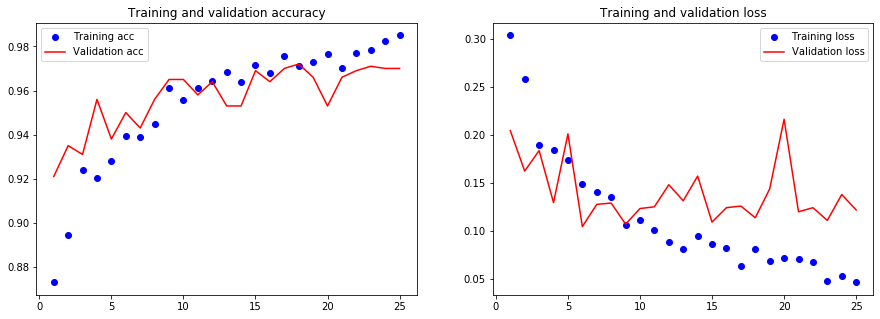

In [0]:
# Plot training / validation results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

fig,a =  plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

a[0].plot(epochs, acc, 'bo', label='Training acc')
a[0].plot(epochs, val_acc, 'r', label='Validation acc')
a[0].set_title('Training and validation accuracy')
a[0].legend()

a[1].plot(epochs, loss, 'bo', label='Training loss')
a[1].plot(epochs, val_loss, 'r', label='Validation loss')
a[1].set_title('Training and validation loss')
a[1].legend()

plt.show()

After fine tuning the pretrained model we've managed to achieve ~97% accuracy on the validation data using augmented train data.

Finally, lets test the model on the test data.


In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test loss: ', test_loss)
print('test accuracy: ', test_acc)

Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
50/50 [==============================] - 5s 93ms/step - loss: 0.1539 - acc: 0.9660
test loss:  0.15389167698459688
test accuracy:  0.966


The fine-tuned model also achieves an accuracy of ~97% on the test set so it generalizes well to unseen data.